In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [35]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import numpy as np

In [36]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()
print(t.__version__)

1.7.0


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
import time

In [72]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

# 测试集
testset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=False,
    num_workers=16
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship


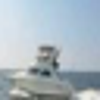

In [86]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

bird       car       horse       bird       cat       truck       plane       plane       dog       frog       deer       ship       plane       car       horse       horse       dog       cat       dog       frog       cat       dog       deer       car       truck       deer       bird       bird       dog       truck       frog       bird


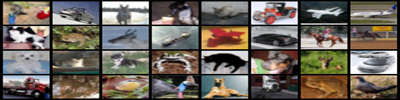

In [87]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

VGGNET是ImageNet2014年的亚军，总结起来就是它使用了更小的滤波器，同时使用了更深的结构，AleNet只有8层网络，而VGGNET有16层~19层网络，也不像AlexNet使用11*11那么大的滤波器，它只使用3*3的卷积滤波器和2*2的大池化层。它之所以使用很多小的滤波器，是因为层叠很多小的滤波器的感受野和一个大的滤波器的感受野是相同的，还能减少参数同时有更深的网络结构  
[![f0I3r9.png](https://z3.ax1x.com/2021/08/12/f0I3r9.png)](https://imgtu.com/i/f0I3r9)

In [63]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11():
    return VGG('VGG11')


def VGG13():
    return VGG('VGG13')


def VGG16():
    return VGG('VGG16')


def VGG19():
    return VGG('VGG19')

# VGG11

In [64]:
vgg11 = VGG11()

In [65]:
for name, param in vgg11.named_parameters():
    print(name, param.size())

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.1.weight torch.Size([64])
features.1.bias torch.Size([64])
features.4.weight torch.Size([128, 64, 3, 3])
features.4.bias torch.Size([128])
features.5.weight torch.Size([128])
features.5.bias torch.Size([128])
features.8.weight torch.Size([256, 128, 3, 3])
features.8.bias torch.Size([256])
features.9.weight torch.Size([256])
features.9.bias torch.Size([256])
features.11.weight torch.Size([256, 256, 3, 3])
features.11.bias torch.Size([256])
features.12.weight torch.Size([256])
features.12.bias torch.Size([256])
features.15.weight torch.Size([512, 256, 3, 3])
features.15.bias torch.Size([512])
features.16.weight torch.Size([512])
features.16.bias torch.Size([512])
features.18.weight torch.Size([512, 512, 3, 3])
features.18.bias torch.Size([512])
features.19.weight torch.Size([512])
features.19.bias torch.Size([512])
features.22.weight torch.Size([512, 512, 3, 3])
features.22.bias torch.Size([512])
featur

In [66]:
# 定义优化器和损失函数
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [67]:
# move the input and model to GPU for speed if available
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [68]:
print(device)

cuda:0


In [69]:
vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [71]:
# 训练网络

all_time =[]
losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = vgg11(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time.append(time_taken)
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            losses.append(running_loss)
            running_loss = 0.0

print(f'Finished Training of VGG11, time_spent: {sum(all_time)}s')

[1,  2000] loss: 1.862
Time: 39.492284059524536
[1,  4000] loss: 1.576
Time: 78.7646746635437
[1,  6000] loss: 1.381
Time: 118.01356077194214
[1,  8000] loss: 1.263
Time: 157.18782234191895
[1, 10000] loss: 1.173
Time: 196.2519495487213
[1, 12000] loss: 1.082
Time: 235.56461238861084
[2,  2000] loss: 0.978
Time: 39.85420036315918
[2,  4000] loss: 0.932
Time: 78.9998881816864
[2,  6000] loss: 0.899
Time: 117.71782922744751
[2,  8000] loss: 0.882
Time: 157.35029196739197
[2, 10000] loss: 0.831
Time: 195.88915514945984
[2, 12000] loss: 0.831
Time: 235.06633400917053
[3,  2000] loss: 0.695
Time: 39.811728715896606
[3,  4000] loss: 0.696
Time: 78.89083623886108
[3,  6000] loss: 0.684
Time: 117.53605771064758
[3,  8000] loss: 0.674
Time: 157.03651642799377
[3, 10000] loss: 0.652
Time: 195.9474868774414
[3, 12000] loss: 0.662
Time: 235.04313111305237
[4,  2000] loss: 0.532
Time: 39.26969075202942
[4,  4000] loss: 0.550
Time: 78.23335361480713
[4,  6000] loss: 0.546
Time: 117.53728580474854
[4

In [73]:
print(f'the total time: {sum(all_time) / 60} min {sum(all_time) % 60} s')

the total time: 178329.74095981914 min 44.4575891494751 s


In [53]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg11(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 95.43 %


In [54]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg11(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 98 %
Accuracy of   car : 98 %
Accuracy of  bird : 90 %
Accuracy of   cat : 93 %
Accuracy of  deer : 98 %
Accuracy of   dog : 93 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %


In [55]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  95.3553607602958


# 吸取VGG11的教训，batch_size从4升至32，训练的实在是太慢了

# VGG13

In [88]:
vgg13 = VGG13()

In [89]:
vgg13.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [90]:
# 定义优化器和损失函数
optimizer = optim.SGD(vgg13.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [91]:
# 训练网络

all_time =[]
losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = vgg13(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time.append(time_taken)
        
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 300))
            print('Time:',time_taken)
            losses.append(running_loss)
            running_loss = 0.0

print(f'Finished Training of VGG13, time_spent: {sum(all_time)}s')

[1,   300] loss: 1.609
Time: 9.852991342544556
[1,   600] loss: 1.277
Time: 18.772430896759033
[1,   900] loss: 1.095
Time: 27.710585355758667
[1,  1200] loss: 0.977
Time: 36.67920255661011
[1,  1500] loss: 0.896
Time: 45.892104148864746
[2,   300] loss: 0.744
Time: 8.885546207427979
[2,   600] loss: 0.718
Time: 17.714457035064697
[2,   900] loss: 0.694
Time: 27.337098836898804
[2,  1200] loss: 0.682
Time: 36.20540118217468
[2,  1500] loss: 0.645
Time: 45.1234929561615
[3,   300] loss: 0.484
Time: 9.39743185043335
[3,   600] loss: 0.503
Time: 18.929520845413208
[3,   900] loss: 0.510
Time: 27.75477147102356
[3,  1200] loss: 0.516
Time: 36.79181480407715
[3,  1500] loss: 0.513
Time: 45.893157720565796
[4,   300] loss: 0.320
Time: 9.643476247787476
[4,   600] loss: 0.346
Time: 18.540907859802246
[4,   900] loss: 0.376
Time: 27.4782075881958
[4,  1200] loss: 0.393
Time: 36.62515902519226
[4,  1500] loss: 0.393
Time: 45.86719059944153
[5,   300] loss: 0.217
Time: 9.004868268966675
[5,   60

In [95]:
print(f'the total time: {sum(all_time) / 60} min {sum(all_time) % 60} s')

the total time: 4361.9366671164835 min 56.200026988983154 s


In [ ]:
# 误差的图像
losses = losses / 30
plt.plot(losses)
plt.ylim(0, max(losses) + 0.05)

In [112]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg13(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96.65 %


In [113]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg13(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 99 %
Accuracy of  bird : 95 %
Accuracy of   cat : 95 %
Accuracy of  deer : 96 %
Accuracy of   dog : 96 %
Accuracy of  frog : 97 %
Accuracy of horse : 98 %
Accuracy of  ship : 98 %
Accuracy of truck : 98 %


In [114]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  96.9544896982147


# VGG16

In [99]:
vgg16 = VGG16()

In [100]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [101]:
# 定义优化器和损失函数
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [102]:
# 训练网络

all_time =[]
losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = vgg16(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time.append(time_taken)
        
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 300))
            print('Time:',time_taken)
            losses.append(running_loss)
            running_loss = 0.0

print(f'Finished Training of VGG13, time_spent: {sum(all_time)}s')

[1,   300] loss: 1.666
Time: 11.263596296310425
[1,   600] loss: 1.340
Time: 21.587876081466675
[1,   900] loss: 1.179
Time: 31.903995037078857
[1,  1200] loss: 1.030
Time: 42.92871165275574
[1,  1500] loss: 0.957
Time: 53.374332904815674
[2,   300] loss: 0.773
Time: 10.400243043899536
[2,   600] loss: 0.773
Time: 21.206473350524902
[2,   900] loss: 0.738
Time: 31.489521026611328
[2,  1200] loss: 0.696
Time: 41.787797927856445
[2,  1500] loss: 0.704
Time: 52.15536570549011
[3,   300] loss: 0.534
Time: 10.581623554229736
[3,   600] loss: 0.549
Time: 21.333945274353027
[3,   900] loss: 0.553
Time: 31.709681510925293
[3,  1200] loss: 0.549
Time: 42.19675922393799
[3,  1500] loss: 0.523
Time: 53.333418130874634
[4,   300] loss: 0.365
Time: 10.51299524307251
[4,   600] loss: 0.393
Time: 20.751660108566284
[4,   900] loss: 0.406
Time: 31.056265115737915
[4,  1200] loss: 0.412
Time: 41.95893120765686
[4,  1500] loss: 0.416
Time: 52.292041063308716
[5,   300] loss: 0.252
Time: 10.4848904609680

In [104]:
# 误差的图像
# losses = losses / 30
# plt.plot(losses)
# plt.ylim(0, max(losses) + 0.05)

In [115]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96.14 %


In [116]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 98 %
Accuracy of   car : 97 %
Accuracy of  bird : 96 %
Accuracy of   cat : 94 %
Accuracy of  deer : 97 %
Accuracy of   dog : 85 %
Accuracy of  frog : 97 %
Accuracy of horse : 98 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %


In [117]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  96.27736088907349


# VGG19

In [118]:
vgg19 = VGG19()

In [119]:
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [120]:
# 定义优化器和损失函数
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [121]:
# 训练网络

all_time =[]
losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = vgg19(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time.append(time_taken)
        
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 300))
            print('Time:',time_taken)
            losses.append(running_loss)
            running_loss = 0.0

print(f'Finished Training of VGG19, time_spent: {sum(all_time)}s')

[1,   300] loss: 1.753
Time: 12.537637710571289
[1,   600] loss: 1.438
Time: 24.65788507461548
[1,   900] loss: 1.234
Time: 37.29936742782593
[1,  1200] loss: 1.128
Time: 49.62393236160278
[1,  1500] loss: 1.032
Time: 61.97135543823242
[2,   300] loss: 0.872
Time: 12.468068361282349
[2,   600] loss: 0.844
Time: 24.849826335906982
[2,   900] loss: 0.809
Time: 36.99063467979431
[2,  1200] loss: 0.756
Time: 49.66532278060913
[2,  1500] loss: 0.747
Time: 61.875736236572266
[3,   300] loss: 0.615
Time: 12.226846694946289
[3,   600] loss: 0.603
Time: 24.82677912712097
[3,   900] loss: 0.608
Time: 37.004592418670654
[3,  1200] loss: 0.579
Time: 49.257689237594604
[3,  1500] loss: 0.582
Time: 61.8939573764801
[4,   300] loss: 0.439
Time: 12.232437133789062
[4,   600] loss: 0.457
Time: 24.46225666999817
[4,   900] loss: 0.477
Time: 37.13679528236389
[4,  1200] loss: 0.448
Time: 49.44883346557617
[4,  1500] loss: 0.455
Time: 61.707106590270996
[5,   300] loss: 0.326
Time: 13.22965931892395
[5,  

In [122]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94.42 %


In [123]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 85 %
Accuracy of   cat : 86 %
Accuracy of  deer : 95 %
Accuracy of   dog : 95 %
Accuracy of  frog : 95 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %


In [124]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  93.71383489631998
